# MIE 1624 Assignment 1: Sentiment Analysis

Starts by importing libraries that are used for data cleaning.

In [1]:
# !pip3 install pandas numpy --user
# !pip3 install --user
# !pip3 install HTMLParser --user
# !pip3 install nltk --user

import pandas as pd
import numpy as np
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt

%matplotlib inline

import sys
print(sys.version) # showing current python version

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/richard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/richard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/richard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


## Part 1: Data Cleaning

### 1.1 Reading Files

In [2]:
generic_tweets = pd.read_csv('generic_tweets.txt', parse_dates=['date'])
generic_tweets.head()

/home/richard/.local/lib/python3.5/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
airline_tweets = pd.read_csv('US_airline_tweets.csv')
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


In [4]:
colnames=['word', 'score'] # defining column names for the file
corpus=pd.read_csv('corpus.txt', names=colnames, delim_whitespace=True) #read in the file, give columns a name, use whitespace as deimiter
corpus.head()

,word,score
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [5]:
colnames=['word']
stop_words=pd.read_csv('stop_words.txt',names=colnames) #read in the file, give column a name
stop_words.head()

,word
0,a
1,able
2,about
3,above
4,abst


### 1.2 [Remove HTML tags and attributes](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and return HTML character codes (i.e., &...;) with an ASCII equivalent

In [6]:
# defining function to be applied to all tweet
def parse(text):
    """
    remove html tags and attributes using beautifulSoup html.parser
    returns output as text
    """
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

In [7]:
generic_tweets['text']=generic_tweets['text'].apply(parse)
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
airline_tweets['text']=airline_tweets['text'].apply(parse)
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


### 1.3 [Normalize Unicode character with regular text](https://stackoverflow.com/a/3194567/10251025)

In [9]:
def normalize(text):
    """
    normalizes unicode character to regular text
    Example: normalize('Cześć')='Czesc'
    """
    # read ascii characters using NFKD method, then decode back to string
    text=unicodedata.normalize('NFKD',text).encode('ascii', 'ignore').decode('utf-8')
    return text

In [10]:
generic_tweets['text']=generic_tweets['text'].apply(normalize)
airline_tweets['text']=airline_tweets['text'].apply(normalize)

### 1.4 [Removing URL](https://docs.python.org/2/library/re.html)

In [11]:
def remove_URL(text):
    """
    removes URL within a string by matching a pattern
    pattern: http or www until 1st white space seen
    """
    try:
        text = re.sub(r'http\S+\s+', '', text) #match pattern http followed by any non whitespace followed by white space, replace with nothing
        text = re.sub(r'www\S+\s+', '', text)#match pattern www followed by any non whitespace followed by white space, replace with nothing
    except:
        text = text
    return(text)

In [12]:
generic_tweets['text']=generic_tweets['text'].apply(remove_URL)
airline_tweets['text']=airline_tweets['text'].apply(remove_URL)

### 1.5 Removing non letter and white spaces

In [13]:
def remove_ws(text):
    """
    Removing extra whitespace, trailing and leading white spaces
    """
    try:
        text=re.sub(r'\s+', ' ', text) #removes extra white space, strip leading and trailing white space
        text=text.lower() #make all text lower case
    except:
        text=text
    return text

In [14]:
def remove_nonletter(text):
    """
    removes non a-z or A-Z letters
    """
    try:
        text=re.sub(r'[^a-zA-Z ]+', ' ', text) #matching anything that is not in the a-z, A-Z and white space set, replace with white space
    except:
        text=text
    return text

In [15]:
#removing white space and non letter from generic_tweets dataframe
generic_tweets['text']=generic_tweets['text'].apply(remove_nonletter)
generic_tweets['text']=generic_tweets['text'].apply(remove_ws)

In [16]:
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,switchfoot athat s a bummer you shoulda got d...
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can t update his facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,kenichan i dived many times for the ball mana...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,nationwideclass no it s not behaving at all i...


### 1.6 [Storing airline mentions](https://stackoverflow.com/a/43958095/10251025)

In [17]:
#removing white space from airline_tweets dataframe
airline_tweets['text']=airline_tweets['text'].apply(remove_ws)

In [18]:
#define a tuple of airline names. This is to find the actual airline mention within a tweet
airlines={'@virginamerica':'virginamerica', '@united':'united', '@southwestair':'southwestair', '@jetblue':'jetblue','@usairways':'usairways', '@americanair':'americanair', '@deltaassist':'deltaassist'}

def find_mentions(text):
    global airlines
    text=re.findall(r'@\S+',text)
    if len(text)>=1:
        for i in text:
            for j in airlines:
                if j in i:return airlines[j]

In [19]:
airline_tweets['airline']=airline_tweets['text'].apply(find_mentions)
airline_tweets['text']=airline_tweets['text'].apply(remove_nonletter)
airline_tweets['airline'].unique()

array(['virginamerica', 'united', 'southwestair', 'jetblue', None,
       'usairways', 'americanair', 'deltaassist'], dtype=object)

In [20]:
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text,airline
0,5.703010e+17,positive,NaN,jnardino,0,virginamerica plus you ve added commercials t...,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,virginamerica it s really aggressive to blast...,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica and it s a really big bad thing...,virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica seriously would pay a flight ...,virginamerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,virginamerica yes nearly every time i fly vx...,virginamerica


In [21]:
airline_tweets['airline'].unique()

array(['virginamerica', 'united', 'southwestair', 'jetblue', None,
       'usairways', 'americanair', 'deltaassist'], dtype=object)

In [22]:
airline_tweets[airline_tweets['airline'].isnull()]

,id,sentiment,negative_reason,user,retweet_count,text,airline
6184,5.686020e+17,positive,NaN,JetBlue,3,ninadavuluri we think it s a treat to have yo...,None


In [23]:
# removing the tweet where Jetblue replied to a user
airline_tweets=airline_tweets.dropna(subset=['airline'])
airline_tweets[airline_tweets['airline'].isnull()]

,id,sentiment,negative_reason,user,retweet_count,text,airline


### 1.7 Remove stop words

In [24]:
# getting ntlk stop word list into dataframe
stop_words_ntlk=pd.DataFrame(data=list(stopwords.words('english')), columns=['word'])
print(len(stop_words_ntlk))
stop_words_ntlk.head()

179


,word
0,i
1,me
2,my
3,myself
4,we


In [25]:
#considering the names of the airlines as stopwords aswell since they do not add any value to the analysis
airlines_values=pd.DataFrame(data=list(airlines.values()), columns=['word'])
airlines_values.head()

,word
0,deltaassist
1,usairways
2,jetblue
3,americanair
4,virginamerica


In [26]:
# combining given stop_word list, ntlk stop_word list and airline names
# stop_words_combined=stop_words.append([stop_words_ntlk, airlines_values], ignore_index=True).drop_duplicates().reset_index(drop=True)
stop_words_combined=stop_words_ntlk
print(len(stop_words_combined))
stop_words_combined.tail()

179


,word
174,weren't
175,won
176,won't
177,wouldn
178,wouldn't


In [27]:
# tokenizing the text and removing stop words for airline tweets
airline_tweets['text']=airline_tweets['text'].apply(lambda x : x.split())
airline_tweets['text']=airline_tweets['text'].apply(lambda y : [word for word in y if word not in stop_words_combined.values])
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text,airline
0,5.703010e+17,positive,NaN,jnardino,0,"[virginamerica, plus, added, commercials, expe...",virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,"[virginamerica, really, aggressive, blast, obn...",virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,"[virginamerica, really, big, bad, thing]",virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,"[virginamerica, seriously, would, pay, flight,...",virginamerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,"[virginamerica, yes, nearly, every, time, fly,...",virginamerica


In [28]:
# tokenizing the text and removing stop words for generic tweets
generic_tweets['text']=generic_tweets['text'].apply(lambda x : x.split())
generic_tweets['text']=generic_tweets['text'].apply(lambda y : [word for word in y if word not in stop_words_combined.values])
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"[switchfoot, athat, bummer, shoulda, got, davi..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,"[kenichan, dived, many, times, ball, managed, ..."
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,"[whole, body, feels, itchy, like, fire]"
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"[nationwideclass, behaving, mad, see]"


### 1.8 Lemmatising

In [30]:
# construct lemmatising

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatising (text):
    x = [lemmatizer.lemmatize(word) for word in text]
    return x

generic_tweets['text']=generic_tweets.text.apply(lemmatising)

In [31]:
# airline_tweets['text']=airline_tweets.text.apply(stemming)
airline_tweets['text']=airline_tweets.text.apply(lemmatising)

## Part 2: Exploratory Analysis

### 2.1 Extract airline mentions


this is already done in step 1.6. Was done before removing the stop words since the name of the airline doesn't add sentiment to the analysis. Below is a visualization of the number of mentions of each airline.

In [32]:
print(airline_tweets['airline'].value_counts(normalize=True));print('\n')
print(airline_tweets['airline'].value_counts());print('\n')
print('Total Tweet Count: '+ str(airline_tweets['airline'].value_counts().values.sum()))

united           0.270711
usairways        0.219411
americanair      0.198960
southwestair     0.152253
jetblue          0.129636
virginamerica    0.028856
deltaassist      0.000173
Name: airline, dtype: float64


united           3124
usairways        2532
americanair      2296
southwestair     1757
jetblue          1496
virginamerica     333
deltaassist         2
Name: airline, dtype: int64


Total Tweet Count: 11540


In [33]:
#showing all airline tweets that sentiment column has the value 'negative' and group by the airline column ...
#...showing only sentiment column, and count them
tmp=airline_tweets[airline_tweets.sentiment=='negative'].groupby('airline').sentiment.agg(['count'])
tmp.columns=['negative']
tmp2=airline_tweets[airline_tweets.sentiment=='positive'].groupby('airline').sentiment.agg(['count'])
tmp2.columns=['positive']
tmp=tmp.join(tmp2).fillna(0)
tmp['%neg']=tmp.apply(lambda x: int(x['negative'])/(int(x['positive'])+int(x['negative']))*100,axis=1)
tmp['%pos']=tmp.apply(lambda x: int(x['positive'])/(int(x['positive'])+int(x['negative']))*100,axis=1)
tmp['total']=tmp.apply(lambda x: (int(x['positive'])+int(x['negative'])),axis=1)
tmp=tmp.sort_values(by=['total'], ascending=False)
tmp2=None
tmp
# print(tmp);print('\n')


,negative,positive,%neg,%pos,total
airline,,,,,
united,2632,492.0,84.250960,15.749040,3124
usairways,2263,269.0,89.375987,10.624013,2532
americanair,1960,336.0,85.365854,14.634146,2296
southwestair,1187,570.0,67.558338,32.441662,1757
jetblue,953,543.0,63.703209,36.296791,1496
virginamerica,181,152.0,54.354354,45.645646,333
deltaassist,2,0.0,100.000000,0.000000,2


**Observation**

There are total of around 11540 tweets that mentioned an airline. 

Of these tweets, [United](https://twitter.com/united?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) airline has the most mentions at 3124 (27.07%) mentions, and [Delta Assist](https://twitter.com/deltaassist?lang=en) (which refers to delta airlines) has the least mentions at 2, which is 0.02% of total number of mentions. 

[US airways](https://twitter.com/USAirways?lang=en) and [American Air](https://twitter.com/AmericanAir?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) has similar number of mentions, at 2532 (21.94%) and 2296 (19.90%) respectively.

United, US Airways and American air all recieved similar percentages of negative comments, around 84~89% range, and virginamerica recieved the most percentage of positive comments, at 45.6%.

### 2.2 Dataset Visualization

#### Plot for US Airline Tweets

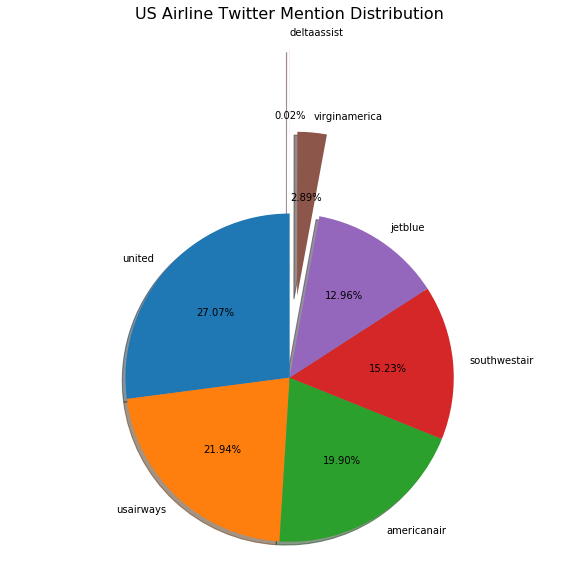

In [34]:
labels = list(airline_tweets['airline'].value_counts().keys())
sizes = list(airline_tweets['airline'].value_counts().values)
explode = (0, 0, 0, 0, 0, 0.5, 1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', startangle=90, shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig = plt.gcf()
fig.set_size_inches(10,10) # or (4,4) or (5,5) or whatever
plt.title('US Airline Twitter Mention Distribution', fontsize=16)
plt.show()

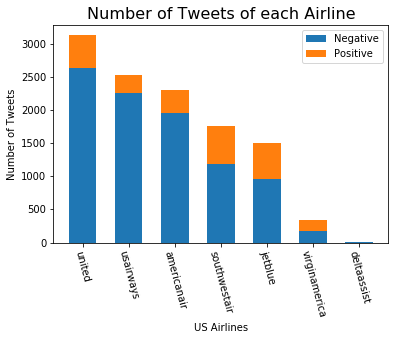

In [36]:
labels = list(tmp.index.values)

neg = (list(tmp.negative.values))
pos = (list(tmp.positive.values))
ind = np.arange(len(labels))    # the x locations for the groups
width = 0.6     # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, neg, width)
p2 = plt.bar(ind, pos, width, bottom=neg)

plt.ylabel('Number of Tweets')
plt.xlabel('US Airlines')
plt.title('Number of Tweets of each Airline', fontsize=16)
plt.xticks(ind, labels)
# plt.yticks(np.arange(0, 81, 10))
plt.xticks(rotation=-75)
plt.legend((p1[0], p2[0]), ('Negative', 'Positive'))

plt.show()

#### Plot for Generic Tweets

In [300]:
generic_tweets['length'] = generic_tweets['text'].apply(len)
generic_tweets.head()

,class,id,date,query,user,text,length
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"[switchfoot, athat, bummer, shoulda, got, davi...",9
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,...",11
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,"[kenichan, dived, many, time, ball, managed, s...",10
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]",6
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"[nationwideclass, behaving, mad, see]",4


In [38]:
generic_tweets[generic_tweets['class'] == 1]['length'].values

array([], dtype=int64)

Text(-0.04, 0.5, 'Frequency')

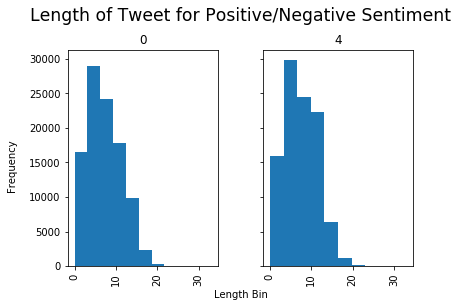

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
generic_tweets.hist('length', by='class', ax=axes)
plt.suptitle('Length of Tweet for Positive/Negative Sentiment', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Length Bin', ha='center')
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf343891d0>]],
      dtype=object)

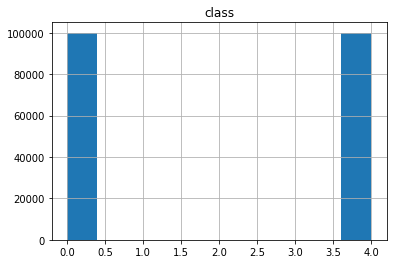

In [40]:
generic_tweets.hist('class')

## 3. Model Preparation

In [309]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

In [180]:
# function for plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, fs=(12,12),font_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

    plt.figure(figsize=fs);
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=font_size)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=font_size-2)
    plt.xlabel('Predicted label', fontsize=font_size-2)
    plt.tight_layout()

In [173]:
def make_str(text):
    y=''
    for x in text:
        y= y+' '+x
    return y

**Model Prep Starts Here**

In [174]:
generic_tweets_vec=generic_tweets.copy()
generic_tweets_vec.text=generic_tweets_vec.text.apply(make_str)

generic_tweets_vec['sentiment'] = np.where(generic_tweets_vec['class']==4, 'positive', 'negative')

In [175]:
cv=CountVectorizer()
tfidf = TfidfTransformer()

generic_bag=cv.fit_transform(generic_tweets_vec.text)
generic_trans = tfidf.fit_transform(generic_bag)

generic_trans.shape

(200000, 127767)

In [176]:
X=generic_trans
Y=generic_tweets_vec['sentiment']

X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [177]:
model=LogisticRegression()

model.fit(X_train,Y_train)

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [178]:
y_pred=model.predict(X_test)

Accuracy Score: 0.77


              precision    recall  f1-score   support

    negative       0.79      0.74      0.76     29981
    positive       0.76      0.80      0.78     30019

   micro avg       0.77      0.77      0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000



<Figure size 432x288 with 0 Axes>

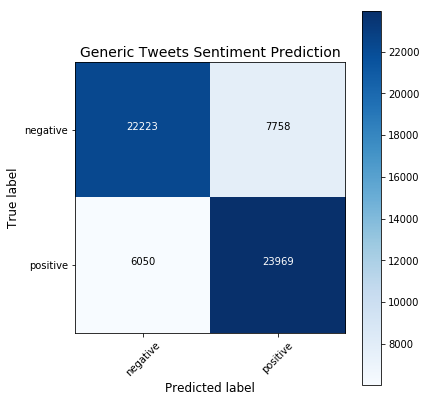

In [184]:
print ('Accuracy Score: ' + str(round(accuracy_score(Y_test, y_pred),3)))
print ('\n')
print(classification_report(Y_test,y_pred))

ticklabel=generic_tweets_vec['sentiment'].unique()
cm=metrics.confusion_matrix(Y_test, y_pred, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Generic Tweets Sentiment Prediction', fs=(6,6), font_size=14)

## 4. Model Implementation

### 4.1 Eavluating Airline Model with Generic Tweets Model

In [185]:
airline_tweets_vec=airline_tweets.copy()
airline_tweets_vec.text=airline_tweets_vec.text.apply(make_str)

In [186]:
airline_bag=cv.transform(airline_tweets_vec.text)
airline_trans = tfidf.transform(airline_bag)

airline_trans.shape

(11540, 127767)

In [187]:
y_pred_air=model.predict(airline_trans)

In [188]:
y_pred_air

array(['positive', 'positive', 'negative', ..., 'positive', 'negative',
       'negative'], dtype=object)

0.763
              precision    recall  f1-score   support

    negative       0.96      0.74      0.83      9178
    positive       0.46      0.87      0.60      2362

   micro avg       0.76      0.76      0.76     11540
   macro avg       0.71      0.80      0.72     11540
weighted avg       0.85      0.76      0.78     11540



<Figure size 432x288 with 0 Axes>

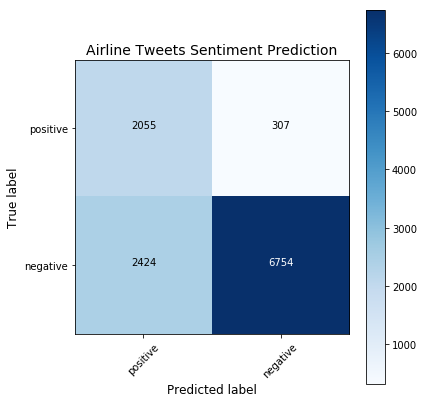

In [189]:
ticklabel=airline_tweets_vec.sentiment.unique()
cm=metrics.confusion_matrix(airline_tweets_vec.sentiment, y_pred_air, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Airline Tweets Sentiment Prediction', fs=(6,6), font_size=14)
print (round(accuracy_score(airline_tweets_vec.sentiment, y_pred_air),3))
print(classification_report(airline_tweets_vec.sentiment, y_pred_air))

### 4.2 Training a Airline Logistic Regression Model

In [190]:
model_airline=LogisticRegression()

airline_bag=cv.fit_transform(airline_tweets_vec.text)
airline_fit = TfidfTransformer().fit(airline_bag)
airline_trans = airline_fit.transform(airline_bag)
airline_trans.shape

X_air=airline_trans
Y_air=airline_tweets_vec['sentiment']

X_train_air, X_test_air, Y_train_air, Y_test_air=train_test_split(X_air,Y_air,test_size=0.3)

model_airline.fit(X_train_air,Y_train_air)

y_pred_air=model_airline.predict(X_test_air)

ticklabel=airline_tweets_vec.sentiment.unique()
cm=metrics.confusion_matrix(Y_test_air, y_pred_air, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Airline Tweets Sentiment Prediction', fs=(6,6), font_size=14)
print (round(accuracy_score(Y_test_air, y_pred_air),3))
print(classification_report(Y_test_air, y_pred_air))

### 4.3 Airline Multi-Class logistic regression model

In [310]:
airline_tweets_neg=airline_tweets_vec[airline_tweets_vec.sentiment=='negative']

In [311]:
airline_tweets_neg.negative_reason.value_counts(normalize=True)

Customer Service Issue         0.317063
Late Flight                    0.181412
Can't Tell                     0.129658
Cancelled Flight               0.092286
Lost Luggage                   0.078884
Bad Flight                     0.063195
Flight Booking Problems        0.057638
Flight Attendant Complaints    0.052408
longlines                      0.019394
Damaged Luggage                0.008063
Name: negative_reason, dtype: float64

Given negative reason categories *Damaged Luggage* and *longlines* only account for 0.8% and 2% of total negative reasons, the dataset sample is fairly biased against predicting these two values correctly, thus *Damaged Luggage* is grouped into *Lost luggage* and is renamed into *Luggage Issues*. Longlines is grouped into *Customer Service Issue*

In [312]:
airline_tweets_neg['negative_reason']=airline_tweets_neg['negative_reason'].apply(lambda x : 'Customer Service Issue' if (x == "longlines") else 'Luggage Issue' if (x=='Damaged Luggage' or x == 'Lost Luggage') else x);
airline_tweets_neg.negative_reason.value_counts(normalize=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Customer Service Issue         0.336457
Late Flight                    0.181412
Can't Tell                     0.129658
Cancelled Flight               0.092286
Luggage Issue                  0.086947
Bad Flight                     0.063195
Flight Booking Problems        0.057638
Flight Attendant Complaints    0.052408
Name: negative_reason, dtype: float64

In [313]:
airline_tweets_neg.head()

,id,sentiment,negative_reason,user,retweet_count,text,airline
1,5.703010e+17,negative,Bad Flight,jnardino,0,virginamerica really aggressive blast obnoxio...,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica really big bad thing,virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica seriously would pay flight seat...,virginamerica
11,5.702820e+17,negative,Late Flight,smartwatermelon,0,virginamerica sfo pdx schedule still mia,virginamerica
13,5.702770e+17,negative,Bad Flight,heatherovieda,0,virginamerica flew nyc sfo last week fully si...,virginamerica


In [314]:
cv=CountVectorizer()
tfidf = TfidfTransformer()

airline_tweets_neg_text=cv.fit_transform(airline_tweets_neg.text)
airline_neg_trans = tfidf.fit_transform(airline_tweets_neg_text)

airline_neg_trans.shape

(9178, 8905)

In [315]:
X_multi=airline_neg_trans
Y_multi=airline_tweets_neg[airline_tweets_neg.sentiment=='negative'].negative_reason

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(X_multi,Y_multi,test_size=0.3, random_state=101)

In [316]:
# model_multi = LogisticRegression()
model_multi = OneVsRestClassifier(LogisticRegression())

In [317]:
model_multi.fit(X_multi_train, Y_multi_train)

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [318]:
y_multi_predict = model_multi.predict(X_multi_test)

In [319]:
resultsDF = pd.DataFrame({
        'true':Y_multi_test,
        'predicted':y_multi_predict
    })
resultsDF.head()

,predicted,true
10030,Customer Service Issue,Customer Service Issue
10583,Customer Service Issue,Customer Service Issue
5088,Customer Service Issue,Flight Booking Problems
2619,Late Flight,Late Flight
8280,Customer Service Issue,Customer Service Issue


<Figure size 432x288 with 0 Axes>

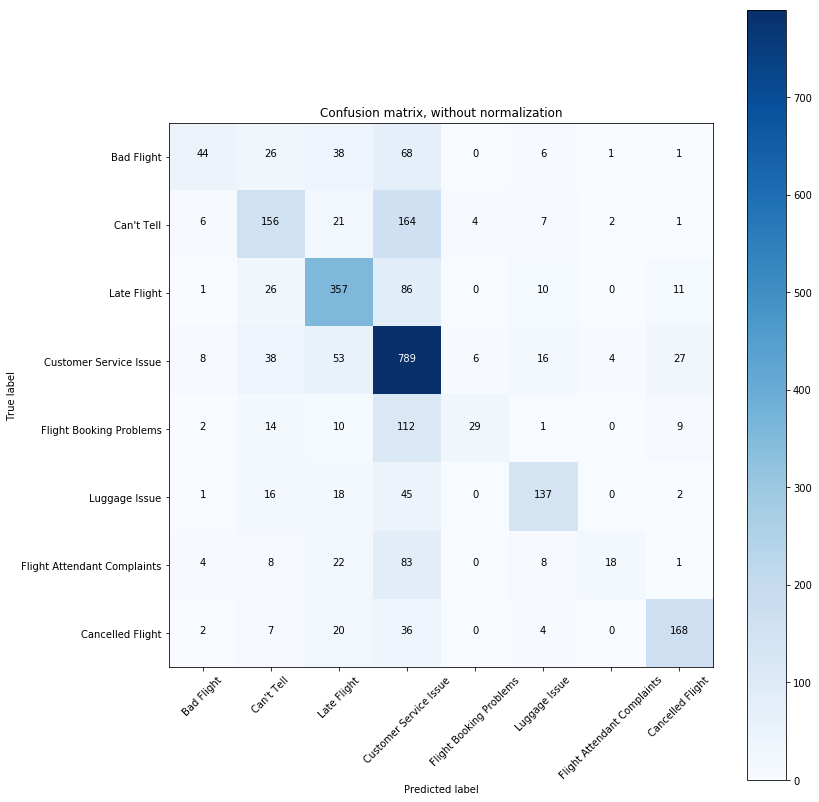

In [320]:
ticklabel=airline_tweets_neg[airline_tweets_neg.sentiment=='negative'].negative_reason.unique()
cm=metrics.confusion_matrix(Y_multi_test, y_multi_predict, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Confusion matrix, without normalization')

In [321]:
print (round(accuracy_score(Y_multi_test, y_multi_predict),3))
print(classification_report(Y_multi_test,y_multi_predict))

0.617
                             precision    recall  f1-score   support

                 Bad Flight       0.65      0.24      0.35       184
                 Can't Tell       0.54      0.43      0.48       361
           Cancelled Flight       0.76      0.71      0.74       237
     Customer Service Issue       0.57      0.84      0.68       941
Flight Attendant Complaints       0.72      0.12      0.21       144
    Flight Booking Problems       0.74      0.16      0.27       177
                Late Flight       0.66      0.73      0.69       491
              Luggage Issue       0.72      0.63      0.67       219

                  micro avg       0.62      0.62      0.62      2754
                  macro avg       0.67      0.48      0.51      2754
               weighted avg       0.64      0.62      0.59      2754

